# Simple Cluster Sampling Example
This method has been developed to be a kind of "smart downsampling" of data used to train machine learning models. We use unsupervised clustering to combine very similar data into groups, and then choose one sample to represent each cluster. We are able to remove redundant samples from the training data, which enables faster model training and more accurate results.

In [1]:
import numpy as np
import kosh
from kosh.operators import KoshCluster, KoshClusterLossPlot, KoshHopkins
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
import h5py
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Create some clustered data
First we're going to use sklearn's make_blobs function to create the dataset. 

We need to have a 2d Numpy array or Pandas dataframe with shape (N_samples, M_features) as inputs to the cluster sampling operator. Later in the notebook I will address ways to deal with 1D or multi-D arrays.

It's also possible to pass more than one Kosh dataset to the clustering operator, but the datasets need to have the same number of features. Here the datasets are shape (750, 2) with 20 clusters, and shape (450, 2) with only one dense cluster. The operator will concatenate the datasets on axis 0.

In [2]:
data1, y = make_blobs(n_samples=750, centers=20, center_box=(0, 20), random_state=3)
data2, y2 = make_blobs(n_samples=450, centers=1, cluster_std=.5, center_box=(0, 20), random_state=1)
data = np.concatenate((data1, data2), axis=0)

Save data as hdf5 files, and associate them with a kosh store.

In [3]:
h5f_1 = h5py.File("clusters_20", 'w')
h5f_1.create_dataset('dataset_1', data=data1)
h5f_1.close()

h5f_2 = h5py.File("one_dense_cluster", 'w')
h5f_2.create_dataset('dataset_2', data=data2)
h5f_2.close()

In [4]:
cluster_sql_file = "clusters.sql"
store = kosh.connect(cluster_sql_file, delete_all_contents=True)

dataset = store.create("cluster_example1")
dataset.associate(["clusters_20", "one_dense_cluster"], "hdf5")

['dd09257ce7ed40ad920a01af8b766680', '27d3da81297242dca9e3ff833c18c882']

## Visualize the data
In this case our data only have two dimensions so we can easily visualize the distribution and clustering tendency.

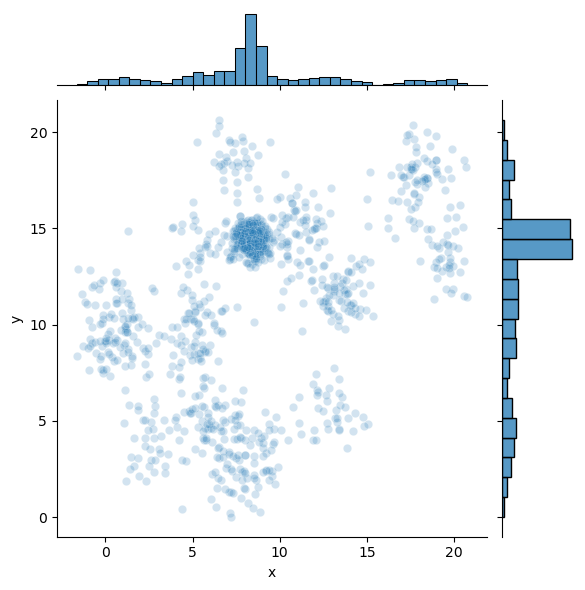

In [5]:
data_pd = pd.DataFrame(data, columns=['x','y'])
sns.jointplot(x=data_pd['x'], y=data_pd['y'], kind='scatter', alpha=.2)

## Check clustering tendency of data
Data sets with more dimensions are difficult to understand the clustering tendency. The Hopkins test value measures the cluster tendendency of our data, and gives us an idea of how much cluster sampling will help us reduce the data set. 

A value close to one means it has a very high clustering tendency. A value about .5 would indicate randomly distributed data, and a value of zero would mean uniformly distributed data. The more clustered the data is, the easier it will be to reduce the data set without losing unique information.

We also need to normalize the data before we use these algorithms. We can do this with the scaling_function argument. We can create our own custom scaling function, or use one of the options provided. 'standard' gives each feature a zero mean and unit variance, and 'min_max' gives each feature a range of [0,1].

In [6]:
hopkins_stat = KoshHopkins(dataset["dataset_1"], dataset["dataset_2"], method='DBSCAN', scaling_function='min_max')[:]
hopkins_stat

0.8459733291946178

A hopkins score of 0.86 means the data is quite clustered and we will benefit from using clustering to reduce our dataset. 

## Determine distance with loss plot function
We can also use the lossPlot function to estimate how much information is lost as we cluster and remove redundant data. We will want to use a clustering parameter, distance in this case, that won't result in too much information lost. It looks like most of the sample size reduction occurs between a distance of zero and 0.05. We want to stop the loss of information before it increases too quickly. So a distance of 0.01 seems like a good distance value so we don't lose too much unique information from our dataset. 

In [7]:
vr = np.linspace(1e-8, .1, 100)
plot = KoshClusterLossPlot(dataset['dataset_1'], dataset['dataset_2'],
                           val_range=vr, method='DBSCAN', 
                           val_type='raw', scaling_function='min_max',
                           outputFormat='matplotlib')[:]

100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


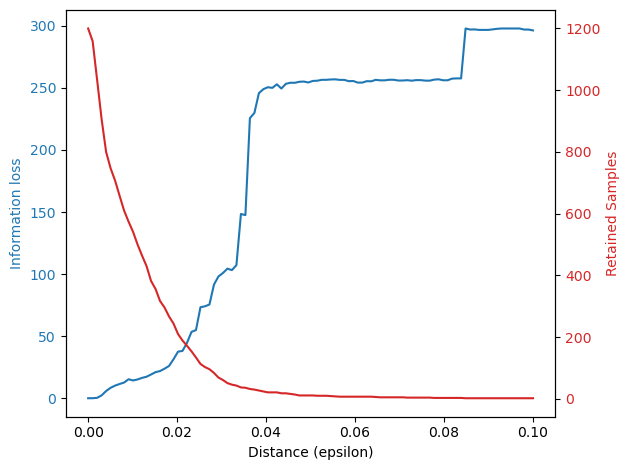

In [8]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Distance (epsilon)')
ax1.set_ylabel("Information loss", color=color)
ax1.plot(plot[0], plot[1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Retained Samples', color=color)
ax2.plot(plot[0], plot[2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Determine distance with the auto_eps algorithm
Another way to find the right distance for clustering is to use the auto_eps algorithm. It will automatically find the epsilon clustering distance based on how much information loss the user is willing to tolerate. In this example we will allow a loss of 10% of the unique information.

We need to set auto_eps to True, and optionally we can also give the algorithm a starting guess with the variable eps_0. Then we need to specify the 10% target loss by setting target_loss=0.1. I'll also set verbose to True so we can see the process of choosing the epsilon value.

In [9]:
reduced_indices, epsilon = KoshCluster(dataset['dataset_1'], dataset['dataset_2'],
                                               scaling_function='min_max', method='DBSCAN',
                                               auto_eps=True, eps_0=0.05, target_loss=.1, 
                                               verbose=True, output='indices')[:]
print("Original data size: %s" % data.shape[0])
print("Reduced data size: %s" % reduced_indices.shape[0])
print("Final epsilon value: %s" % epsilon)

Number of ranks: 1
Reading in 2 datasets.
Total sample size is less than batch size.
epsGuess: 0.05
Loss proportion: 0.8328582045379501
epsGuess: 0.0250000000000005
Loss proportion: 0.2366484948987347
epsGuess: 0.01250000000000075
Loss proportion: 0.05340554952092272
epsGuess: 0.018750000000000627
Loss proportion: 0.09730646955603679
epsFinal: 0.018750000000000627
Final Loss proportion: 0.09730646955603679
Original data size: 1200
Reduced data size: 252
Final epsilon value: 0.018750000000000627


## Cluster data and return representative samples
We will use the distance value from auto_eps to cluster our dataset with DBSCAN. (density-based spatial clustering of applications with noise). 

Make sure to use the same scaling function and clustering method that was used when determining the epsilon distance.

Each cluster will only have datapoints that are very similar to each other. Since we consider everything in the cluster to be about the same we will choose one good representative from each cluster to keep in our final dataset. The default is to use scikit learn's Nearest Neighbors to choose a sample from the most dense part of the cluster. We can return the reduced dataset or just the indices of the samples we want to keep. The second item returned is an estimate of the information lost by removing samples from the original dataset. 

In [10]:
reduced_indices, loss_estimate = KoshCluster(dataset['dataset_1'], dataset['dataset_2'],
                                               scaling_function='min_max', method='DBSCAN',
                                               eps=0.018750000000000627, output='indices')[:]
print("Original data size: %s" % data.shape[0])
print("Reduced data size: %s" % reduced_indices.shape[0])
print("Information loss: %s" % loss_estimate)

Original data size: 1200
Reduced data size: 252
Information loss: 29.866994816593827


## Clustering reduction results
We can see the distribution of the data set reduced with DBSCAN below. The distribution is much more uniform than before. If this data set was being used to train a machine learning model we would have included the output of the model in the clustering. If the output is included in clustering, areas with more output variance would cause us to keep more samples in those areas. We would still be able to reduce the data size making the machine learning model faster to train, and less biased to redundant samples.

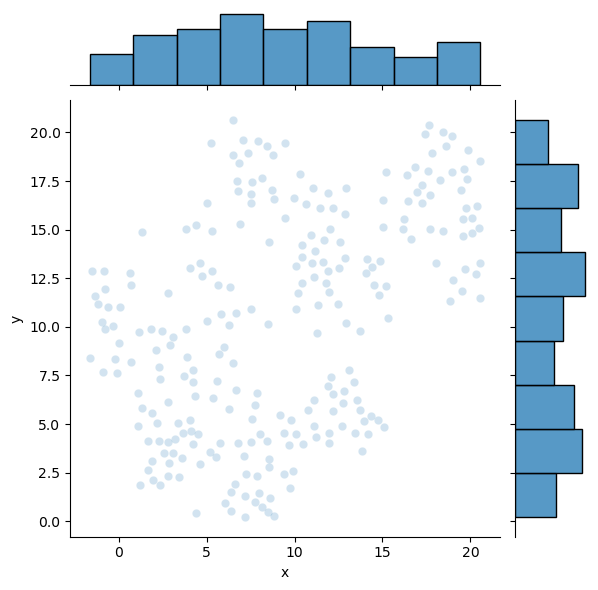

In [11]:
reduced_pd = data_pd.iloc[reduced_indices,:]
sns.jointplot(x=reduced_pd['x'], y=reduced_pd['y'], kind='scatter', alpha=.2)

## Other clustering options
There are two other clustering algorithms available to use: HDBSCAN or hierarchical agglomerative clustering (HAC).

## HDBSCAN
HDBSCAN is a hierarchical approach to DBSCAN (density-based spatial clustering of applications with noise). The benefit to using HDBSCAN is that there is no need to determine the right clustering distance. However you don't have any control over the resulting clustering.

In [12]:
reduced_indices_hdbs, loss_hdbs = KoshCluster(dataset["dataset_1"], dataset["dataset_2"],
                                    method='HDBSCAN', scaling_function='standard',
                                    min_cluster_size=2, output='indices')[:]

print("Original data size: %s" % data.shape[0])
print("Reduced data size: %s" % reduced_indices_hdbs.shape[0])
print("Information loss: %s" % loss_hdbs)

Original data size: 1200
Reduced data size: 524
Information loss: 0


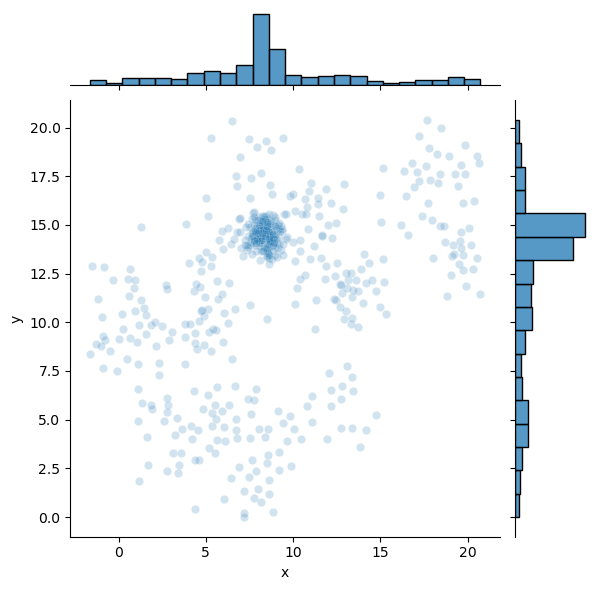

In [13]:
reduced_pd_hdbs = data_pd.iloc[reduced_indices_hdbs,:]
sns.jointplot(x=reduced_pd_hdbs['x'], y=reduced_pd_hdbs['y'], kind='scatter', alpha=.2)

## HAC
Hierarchical Agglomerative Clustering (HAC) is available through scipy. 

In [14]:
reduced_indices_hac, loss_hac = KoshCluster(dataset["dataset_1"], dataset["dataset_2"],
                                method='HAC', scaling_function='standard',
                               HAC_distance_value=.21, output='indices')[:]

print("Original data size: %s" % data.shape[0])
print("Reduced data size: %s" % reduced_indices_hac.shape[0])
print("Information loss: %s" % loss_hac)

Original data size: 1200
Reduced data size: 253
Information loss: 56.31763844271169


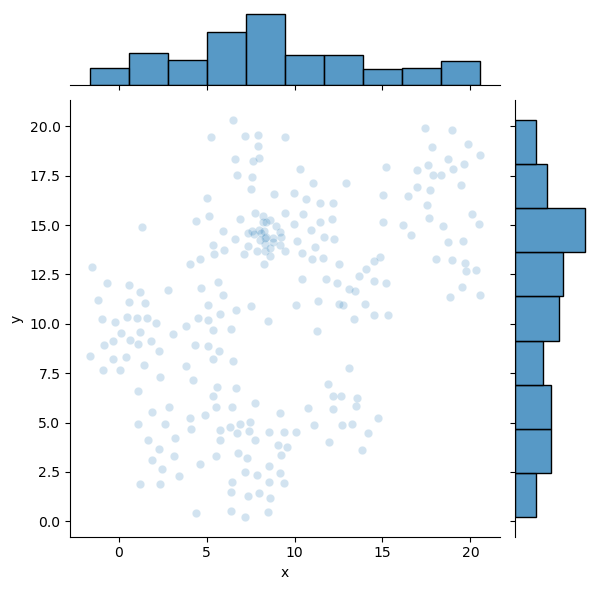

In [15]:
reduced_pd_hac = data_pd.iloc[reduced_indices_hac,:]
sns.jointplot(x=reduced_pd_hac['x'], y=reduced_pd_hac['y'], kind='scatter', alpha=.2)

# Options for large data sets
## Cluster sampling in batches
If the data set is too large to process all at one time we have the option to cluster sample in batches. We only want to use DBSCAN in batches because it is the only deterministic algorithm of the three. 

We also need to set the batch flag to True and specify the batch size.

## Adjusting convergence
We can also adjust the clustering convergence to be more or less conservative. If the convergence_num variable is set to a large integer like 10 that means the data size must be the same for 10 consecutive iterations to be considered converged. If convergence_num is an int between 0. and 1., 0.01 for example, batch clustering will be converged after the change in data size between iterations is less than 0.01 * the original data size. This allows batch clustering to converge faster. The default is to converge after the data size is the same for 2 consecutive iterations (convergence_num=2).

In [16]:
reduced_indices_batch, loss_batch = KoshCluster(dataset["dataset_1"], dataset["dataset_2"],
                                    scaling_function='min_max', method='DBSCAN',
                                    batch=True, batch_size=500, convergence_num=10,
                                    eps=0.018750000000000627,  output='indices')[:]
print("Original data size: %s" % data.shape[0])
print("Reduced data size: %s" % reduced_indices_batch.shape[0])
print("Information loss: %s" % loss_batch)

Original data size: 1200
Reduced data size: 339
Information loss: 18.755573151784265


We haven't reduced the data set as much as we did earlier using DBSCAN without batching. We can quickly get approximately the same amount of reduction, and a more uniform distribution than we did using HAC or HDBSCAN. 

If we wanted to get the same result as before and reduce the data set all the way to 366 samples we would need to set the convergence_num to a higher number like 30. The clustering process would stop after the sample size repeats 30 times. It would take much longer, but you can get approximately the same answer by using a smaller convergence number.

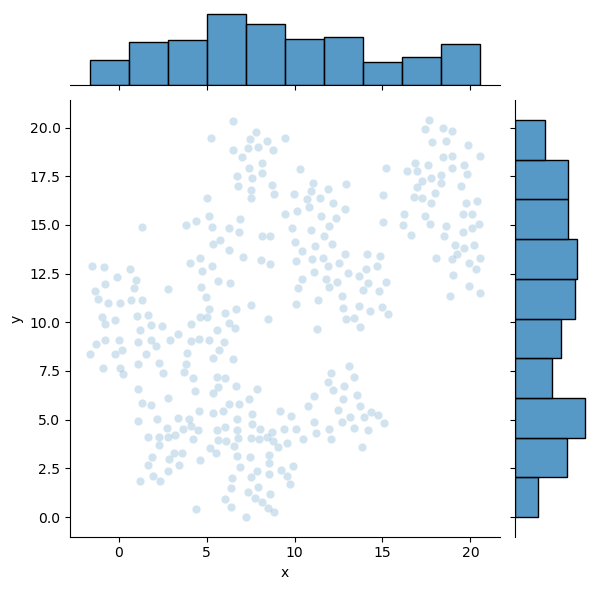

In [17]:
reduced_pd_batch = data_pd.iloc[reduced_indices_batch,:]
sns.jointplot(x=reduced_pd_batch['x'], y=reduced_pd_batch['y'], kind='scatter', alpha=.2)

## Distributed cluster sampling
If the data are too large to read in at once we can cluster sample in batches distributed among many processors.

Resources will need to be allocated with srun or sxterm. For example:

srun -n 16 python <my_file.py>

Here is an example of the code that would be included in my_file.py.

```python
import mpi4py

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nprocs = comm.Get_size()

nsamples = data.shape[0]

# Must include batch=True to run in parallel
reduced_data_parallel = KoshCluster(dataset['dataset_1'], dataset['dataset_2'],
                                    global_ind, comm, method='DBSCAN', eps=.07, 
                                    scaling_function='standard', output='samples',
                                    batch=True, batch_size=3000)

If parallel_output[0] is not None:
    reduced_data = parallel_output[0]
    loss = parallel_output[1]
```

If the data are reduced to a size less than the batch_size all the samples will be moved to rank 0, and processed there. Rank 0 will return a list including [reduced data, loss], and the other ranks will return [None]. It is also possible to use the auto_eps algorithm with parallel batch clustering.

## Accounting for Model Sensitivity
In practice we want to account for model sensitivity. Let's say the model response is more sensitive in a certain area of the input domain. We would want to retain more data in that area. 

By adding the model response as another feature to cluster we can account for model sensitivity. 

Let's create a model response for our previous dataset. The model outputs a 1 everywhere except that dense cluster has a response that varies much more. 

In [18]:
data4 = np.append(np.repeat(1, 750), np.random.randint(20, size=450))
data4

array([ 1,  1,  1, ..., 11,  8, 19])

Now we can add this infomation as a third column in our data array.

In [19]:
print("Starting data shape: " + str(data.shape))
data4 = np.concatenate((data, data4.reshape(-1,1)), axis=1)
print("Data shape with model response added: " + str(data4.shape))

Starting data shape: (1200, 2)
Data shape with model response added: (1200, 3)


In [20]:
h5f_3 = h5py.File("model_response", 'w')
h5f_3.create_dataset('dataset_3', data=data4)
h5f_3.close()
dataset.associate(["model_response"], "hdf5")

['668bdd7fc08c47c4ae8eea8a5b624a37']

We can check to see if the hopkins statistic has changed. Or if we should use a different distance (eps) value. 

In [21]:
new_hopkins = KoshHopkins(dataset["dataset_3"], method='DBSCAN', 
                         scaling_function='standard', sample_ratio=.8)[:]
print("Hopkins value: " + str(new_hopkins))

Hopkins value: 0.9533614306527233


In [22]:
reduced_indices_sensitivity, loss_sensitivity = KoshCluster(dataset["dataset_3"], scaling_function='standard',
                                                 eps=0.019042968750000958, output='indices')[:]
print("Original data size: %s" % data4.shape[0])
print("Reduced data size: %s" % reduced_indices_sensitivity.shape[0])
print("Information loss: %s" % loss_sensitivity)

Original data size: 1200
Reduced data size: 1122
Information loss: 1.0643875419031732


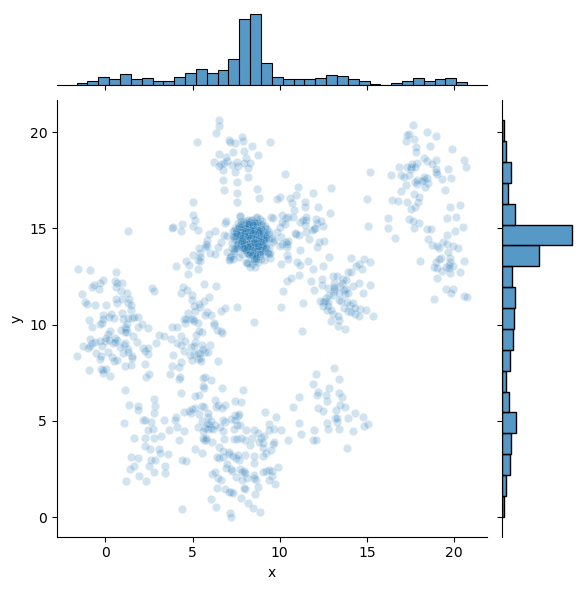

In [23]:
reduced_pd_sens = data_pd.iloc[reduced_indices_sensitivity,:]
sns.jointplot(x=reduced_pd_sens['x'], y=reduced_pd_sens['y'], kind='scatter', alpha=.2)

Success! We retained more data in the area with more model variance.

To simplify the visualization we are still viewing the first two features of the dataset. We can see that by including the response as another feature in the data we retain more samples from the dense cluster which had a more variable response.

## 1D Data Case
For this example our data is stored as 1D arrays, and we need to combine them into a 2D dataset. Consider using something like the following VStack operator that will stack the columns of data vertically. 

Let's suppose we had already stored our clustered data in a kosh store with one dataset containing only the x values, and another dataset with only y values. 

In [24]:
h5f_x = h5py.File("x_values", 'w')
h5f_x.create_dataset('dataset_x', data=data1[:,0])
h5f_x.close()

h5f_y = h5py.File("y_values", 'w')
h5f_y.create_dataset('dataset_y', data=data1[:,1])
h5f_y.close()

store_1d = kosh.connect(cluster_sql_file, delete_all_contents=True)

dataset_1d = store_1d.create("example1d")
dataset_1d.associate(["x_values", "y_values"], "hdf5")

['caf229d990544515bbecab606dd42a40', 'cdcf9e9f2b334f01b48ac051a4e4bf2f']

We can first create a VStack operator to transform the data sets to a shape of (N_samples, M_dimensions). Then we can input the transformed data set into any of the Kosh clustering operators. Here we're finding the Hopkins statistic with our newly transformed data set.

In [25]:
@kosh.numpy_operator
def VStack(*data):
    return np.vstack(data).transpose()

stacked = VStack(dataset_1d["dataset_x"], dataset_1d["dataset_y"])
print("New data shape: ",  stacked[:].shape)
hopkins_stat = KoshHopkins(stacked, method='DBSCAN', scaling_function='standard')[:]
print("Hopkins stat: ", hopkins_stat)

New data shape:  (750, 2)
Hopkins stat:  0.803821002772309


## Multi-D Data Case

KoshCuster was designed to work on data of shape (N samples,M features).  However, there are datasets which don't naturally conform to that size.  In this example we're going to create some image data of higher dimensionality to show how to flatten dimensions, and visualize which samples are retained after clustering. 

The starting image is a from a compressible flow simulation of a cylinder in Mach 2.0 flow. The color contours represent the pressure and you can see the large bow shock forming in front of the cylinder.

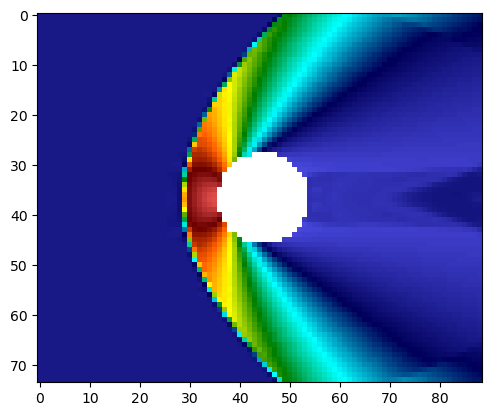

In [26]:
from PIL import Image


my_img = "ss_cylinder.png"
img = Image.open( my_img )
d_img = np.asarray( img )


# Drop the alpha channel from the png file
d_img = d_img[:,:,:3]

# Reduce the image size
factor = 10
r_img = d_img[::factor,::factor,:]

plt.imshow( r_img )

The size of the data from the above image is [74,89,3] which represents [pixels in y, pixels in x, RGB].

Rather than just clustering on each single pixel from the image, we will create many smaller 3x3 images within the larger image.  This is useful because it allows the clustering to consider colors and the local gradient.  Then we can use the cluster sampling algorithm to make a reduced data set that captures all the unique color contours in the image and serve as a form of feature detection. 

In [27]:
samples   = []
locations = []
px  = 1         # patch width (1->3x3, 2->5x5, 3->7x7)

# Looping through image to create smaller images and save center pixel location
for i in range(px, r_img.shape[0]-px  ):
    for j in range(px,  r_img.shape[1]-px  ):
        sample = r_img[i-px:i+px+1,j-px:j+px+1,:]
        samples.append( sample)
        locations.append( [i,j] )

samples   = np.array( samples   )
locations = np.array( locations )
Nsamples  = samples.shape[0]

# Saving image data as hdf5 and associating with Kosh dataset
h5f = h5py.File("cyl_data", 'w')
h5f.create_dataset('cyl_shock', data=samples)
h5f.close()

store_nd = kosh.connect(cluster_sql_file, delete_all_contents=True)

dataset = store_nd.create("exampleND")
dataset.associate(["cyl_data"], "hdf5")

['af5f93e533324885bbac9d1ebcce2be9']

Here's an example of one of the smaller images taken from the front of the shock wave.

Dataset size:  (6264, 3, 3, 3)


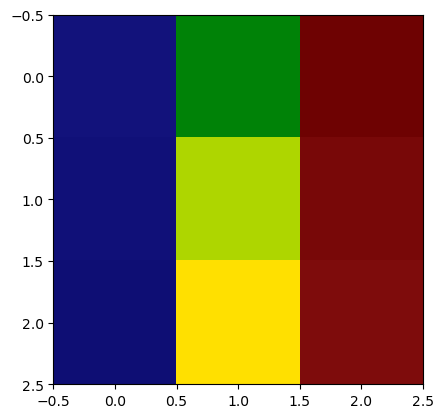

In [28]:
print("Dataset size: ", samples.shape)
plt.imshow(samples[2899,:,:,:])

There are 6,264 images and each image is a 3x3x3 which represents (y pixels, x pixels, [red, green, blue] ).

We need to flatten the last three dimensions so our data set is 2D and can be input into the Kosh clustering operators. We simply use the flatten flag in any of the Kosh clustering operators and the data set will be transformed to the shape (6264, 27).  Returning indices (return='indices') always returns a 1D array of integers.  Returning samples (return='samples') will return a reduced dataset of the new flattened size.

In [29]:
# Using KoshCluster operator to group together similar images and choose a representative from each group.
reduced_indices = KoshCluster(dataset["cyl_shock"], flatten=True,
                                        scaling_function='standard', eps=.4,
                                        output='indices')[:]

print("Original data size: ", Nsamples)
print(" Reduced data size: ", reduced_indices[0].shape[0])
print("     % Compression: ",(1-reduced_indices[0].shape[0]/Nsamples)*100,"%")

Original data size:  6264
 Reduced data size:  894
     % Compression:  85.727969348659 %


Now that we have the indices of the reduced data set, we can plot the retained samples on the original image to show how clustering has selected the unique regions of the flow.


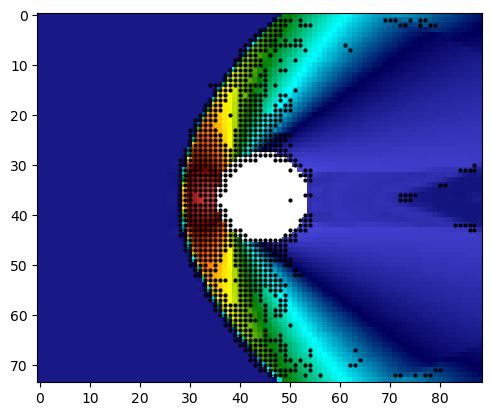

In [30]:
# Plot retained samples on coarse image
plt.imshow( r_img )

for samp in reduced_indices[0]:
    loc = locations[samp]
    plt.plot( loc[1], loc[0], 'ko', markersize=2.)

The samples capture the shock wave and the cylinder and the areas where the pressure is changing.  The above examples reduced the data by more than 85% yet retains the unique components of the shock wave.  Data reduction without loss could be used for many machine learning or data compression applications.